> 02-04 : Simple Models

## Introduction

In this project, we focus on predicting student performance during game-based learning in real-time using the dataset provided in the Kaggle competition titled ["Predict Student Performance from Game Play."](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/) The dataset consists of time series data from an online educational game, containing various features such as elapsed time, event name, level, and more. Our primary goal is to develop a model that can accurately predict whether students will answer questions correctly at different checkpoints in the game.

In recent years, game-based learning has gained traction as an engaging and enjoyable educational approach. By applying deep learning techniques to analyze game-based learning data, we can help researchers and developers create more effective learning experiences for students. Furthermore, the results of our analysis can contribute to the advancement of knowledge-tracing methods in educational games.

The objectives of this project are as follows:

1.	Explore and understand the dataset: Analyze the provided data, preprocess it, and perform feature engineering to extract relevant information for our model.
2.	Develop and train models: Experiment with various model architectures suitable for time series data to find the best model for predicting student performance.
3.	Evaluate model performance: Assess the performance of the developed models on a test dataset using appropriate evaluation metrics.
4.	Optimize the chosen model: Fine-tune the best-performing model to improve accuracy and adhere to the competition compute constraints and efficiency prize requirements.
5.	Document findings: Present the results of our analysis, including the model architectures explored, their performance, and the rationale behind selecting the best model.

By achieving these goals, we aim to create a competitive submission for the Kaggle competition while contributing to improving game-based learning platforms and their ability to support individual students.

### Motivation for Choosing the Dataset

This dataset was chosen for several reasons that align with our objectives and interests in the field of educational technology and data science:

1.	Real-world impact: The dataset offers an opportunity to make a tangible difference in the educational landscape by enhancing game-based learning experiences for students. By developing an accurate predictive model, we can help improve educational games and support educators in tailoring these games to individual student needs.

2.	Advancing research in game-based learning: The dataset presents an opportunity to contribute to knowledge tracing in educational games. By exploring various deep learning techniques, we can advance our understanding of how data science and learning analytics can be applied to game-based learning platforms.

3.	Unique challenge: The time series nature of the dataset provides a unique challenge, requiring us to employ specialized models and techniques to analyze the data effectively. This allows us to broaden our skill set and gain experience working with time series data in the context of educational games.

4.	Efficiency prize: The competition's emphasis on creating small, lightweight, and efficient models adds complexity and encourages us to think critically about our design choices. This competition aspect motivates us to explore innovative solutions that balance model performance with computational constraints.

5.	Collaboration and learning: Participating in a Kaggle competition provides an opportunity to collaborate with a diverse community of data scientists, learn from their experiences, and share our findings. This engagement helps us refine our skills, stay updated on the latest techniques, and contribute to the broader data science community.

By working with this dataset, we hope to address these motivations while gaining valuable insights into the potential of deep learning techniques in enhancing game-based learning experiences for students.


In [1]:
import sys
import logging
from typing import Iterable, List, Tuple

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import keras as k
from keras import callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

2023-03-17 20:28:17.041620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-17 20:28:18.100354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 20:28:18.101937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 20:28:18.102052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-17 20:28:18 INFO     Started


## Data Collection

In [4]:
# the idea for the datatypes were taken from an existing kaggle 
# competition notebook. Sessions are loaded as integers as it
# speeds up queries.
dtypes = {
    "session_id": np.int64,
    "elapsed_time": np.int32,
    "event_name": "category",
    "name": "category",
    "level": np.uint8,
    "page": "category",
    "room_coor_x": np.float32,
    "room_coor_y": np.float32,
    "screen_coor_x": np.float32,
    "screen_coor_y": np.float32,
    "hover_duration": np.float32,
    "text": "category",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": "category",
    "hq": "category",
    "music": "category",
    "level_group": "category",
}

In [5]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz', compression='gzip', dtype=dtypes)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [6]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

### Functions

In [7]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [8]:
def find_problem_sessions(data : pd.DataFrame) -> List[str]:
    """
    Finds the sessions that are duplicated on session_id and index. And
    Find sessions with reversed indexes.

    This idea is taken from the following Kaggle notebook:
    https://www.kaggle.com/code/abaojiang/eda-on-game-progress/notebook?scriptVersionId=120133716
    
    Parameters
    ----------
    data : pd.DataFrame
        The data to search.

    Returns
    -------
    List[str]
        The list of session ids that have a problem.
    """

    # find sessions duplicated on session_id and index
    sessions_with_duplicates = df_source.loc[
        data.duplicated(subset=["session_id", "index"], keep=False)] \
        ["session_id"].unique().tolist()


    # find sessions with reversed indexes
    sessions_with_reversed_index = []
    for sess_id, gp in df_source.groupby("session_id", observed=True):
        if not gp["index"].is_monotonic_increasing:
            sessions_with_reversed_index.append(sess_id)

    # via experimentation these sessions have been found to have time 
    # differences < -2000
    negative_time_diff_sessions = [
        '21030417085341900', '21070111080982292', 
        '21090108302064196', '21090409222921812']

    # combine the two lists into a single set
    return set(sessions_with_duplicates + sessions_with_reversed_index + negative_time_diff_sessions)


In [9]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [10]:
def prepare_main_dataset(data : pd.DataFrame,
                         elapsed_time_min_clip:int=0,
                         elapsed_time_max_clip:int=3691298) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)
    
    # clip the elapsed time to remove outliers
    df_main['elapsed_time'] = df_main['elapsed_time'].clip(
        lower=elapsed_time_min_clip,
        upper=elapsed_time_max_clip)
    
    return df_main

In [11]:
def get_clipping_values(data:pd.DataFrame, column:str, boxplot:bool=True) -> Tuple[float, float]:
    """
    To remove outliers, gets the clipping values for the specified column.

    Parameters
    ----------
    data : pd.DataFrame
        The data to search.
    column : str
        The column to search.
    boxplot : bool, optional
        If True, box plots are show for comparison, by default True.

    Returns
    -------
    Tuple[float, float]
        The clipping values.
    """
    # get the minimum and maximum values
    min_value = data[column].min()
    max_value = data[column].max()

    # get the inter quartile range
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)    
    iq_range = q3 - q1

    # get the clipping values
    min_clip = np.max([min_value, (q1 - (iq_range * 1.5))])
    max_clip = q3 + (iq_range * 1.5)

    # show the box plot
    if boxplot:
        # get the cliped values
        data_clipped = data[column].values.clip(min_clip, max_clip)

        # create the box plot next to each other
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        data[column].plot.box(ax=ax1)
        pd.Series(data_clipped).plot.box(ax=ax2)

        # set the title
        plt.suptitle(f'Box plot for {column}')
        ax1.set_title('Original')
        ax2.set_title('Clipped')

        # show the plot
        plt.show()

    return min_clip, max_clip

### Process the Data

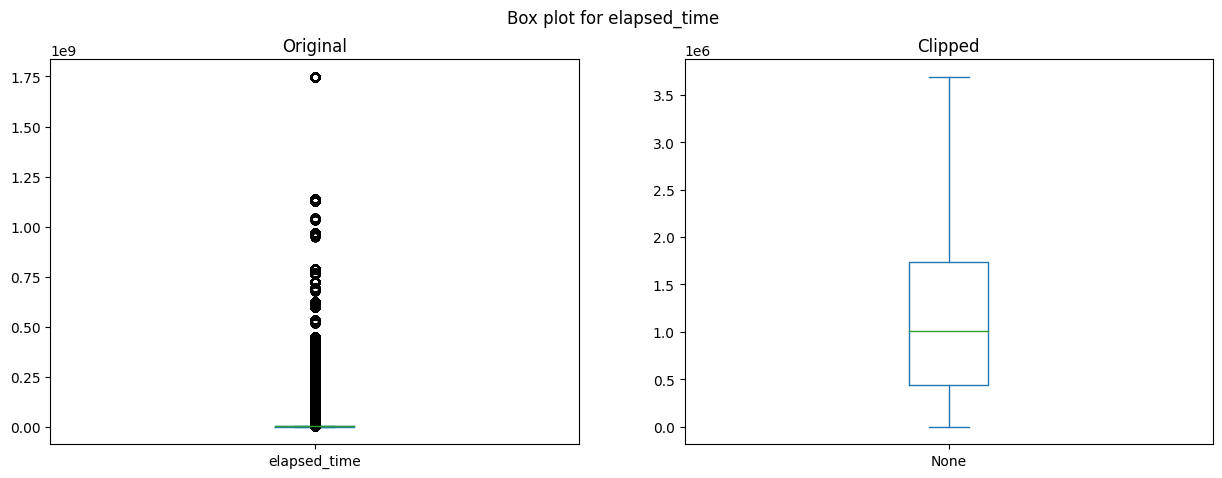

(0.0, 3690980.0)

In [12]:
# show the outliers in the elapsed_time column
get_clipping_values(df_source, 'elapsed_time', boxplot=True)

In [13]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source, elapsed_time_min_clip=0, elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13019794, 14)


,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991394,-159.314682,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [14]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
172317,21070319253640464,15,0,13-22
194865,21040512553883790,17,1,13-22
197728,22000108514966796,17,1,13-22


## Feature Engineering

### Functions

In [15]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which additional features will be added.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.
    y : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The initial feature dataset.
    """
    df_features =  df_source_labels \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \
        
    # set the session_id to be an integer
    df_features['session_id'] = df_features['session_id'].astype(int)
        
    return df_features        

In [16]:
def add_numeric_column_features(features:pd.DataFrame,
                                X:pd.DataFrame,
                                column:str,
                                min_values:dict=None,
                                max_values:dict=None) -> pd.DataFrame:
    """
    Add the maximum elapsed time feature to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The main dataset.
    column : str
        The name of the numeric column to add to the features for.

    Returns
    -------
    None
    """
    # Define a function to calculate mode
    def mode(series):
        return series.mode().iat[0]

    # calculate the maximum, minimum and mean for the column
    df_result = X \
        .groupby(['session_id', 'level_group']) \
        .agg({column: ['sum', 'max', 'min', 'mean', mode]}) \
        .reset_index()
    
    # flatten the multi-index columns
    df_result.columns = ['_'.join(col).rstrip('_') for col in df_result.columns.values]

    # normalize the values
    if min_values is None or max_values is None:
        logging.warning('Not normalizing the values, min_value and max_values are not set.')
    else:
        metric_list = ['sum', 'max', 'min', 'mean', 'mode']
        for metric in metric_list:
            current_column = f'{column}_{metric}'
            df_result[current_column] = (df_result[current_column] - min_values[metric]) / (max_values[metric] - min_values[metric])       

    # join the features to the result   
    df_result = features.set_index(['session_id', 'level_group']) \
        .join(df_result.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    return df_result

In [17]:
def plot_numeric_features(df_features:pd.DataFrame,
                          colum:str) -> None:
    """
    Plot the numeric features for a column.
    """
    metric_list = ['sum', 'max', 'min', 'mean', 'mode']
    column_list = [f'{colum}_{metric}' for metric in metric_list]

    # plot the features
    df_features[column_list].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 10))
    plt.show()

### Create Features

#### Initial Features

In [18]:
# create the initial features
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


#### Elapsed Time

In [19]:
# get the ranges to use for normalizing the values
add_numeric_column_features(df_features, df_source, 'elapsed_time') \
    .describe()

2023-03-17 20:29:00 WARNING  Not normalizing the values, min_value and max_values are not set.


,session_id,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
count,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04
mean,2.114901e+16,4.660743e+08,1.230798e+06,5.986339e+05,9.070864e+05,7.244686e+05
std,5.582462e+14,6.420438e+08,1.056761e+06,7.943308e+05,9.107600e+05,1.006789e+06
min,2.009031e+16,6.139500e+04,9.900000e+02,0.000000e+00,5.264470e+02,0.000000e+00
25%,2.101032e+16,2.832347e+07,3.607190e+05,0.000000e+00,1.641480e+05,0.000000e+00
50%,2.104031e+16,2.037287e+08,8.749455e+05,3.025925e+05,5.875607e+05,3.184355e+05
75%,2.111001e+16,6.577198e+08,1.773885e+06,9.188058e+05,1.338713e+06,9.961275e+05
max,2.210022e+16,9.990648e+09,3.691298e+06,3.691298e+06,3.691298e+06,3.691298e+06


In [20]:
# add the feature to the features dataset
df_features = add_numeric_column_features(
    features=df_features,
    X=df_source,
    column='elapsed_time',
    min_values={
        'sum': 61395.0,
        'max':  990.0,
        'min':  0.0,
        'mean': 526.447,
        'mode': 0.0},
    max_values={
        'sum':  9990648000,
        'max':  3691298.0,
        'min':  3691298.0,
        'mean': 3691298.0,
        'mode': 3691298.0})

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301


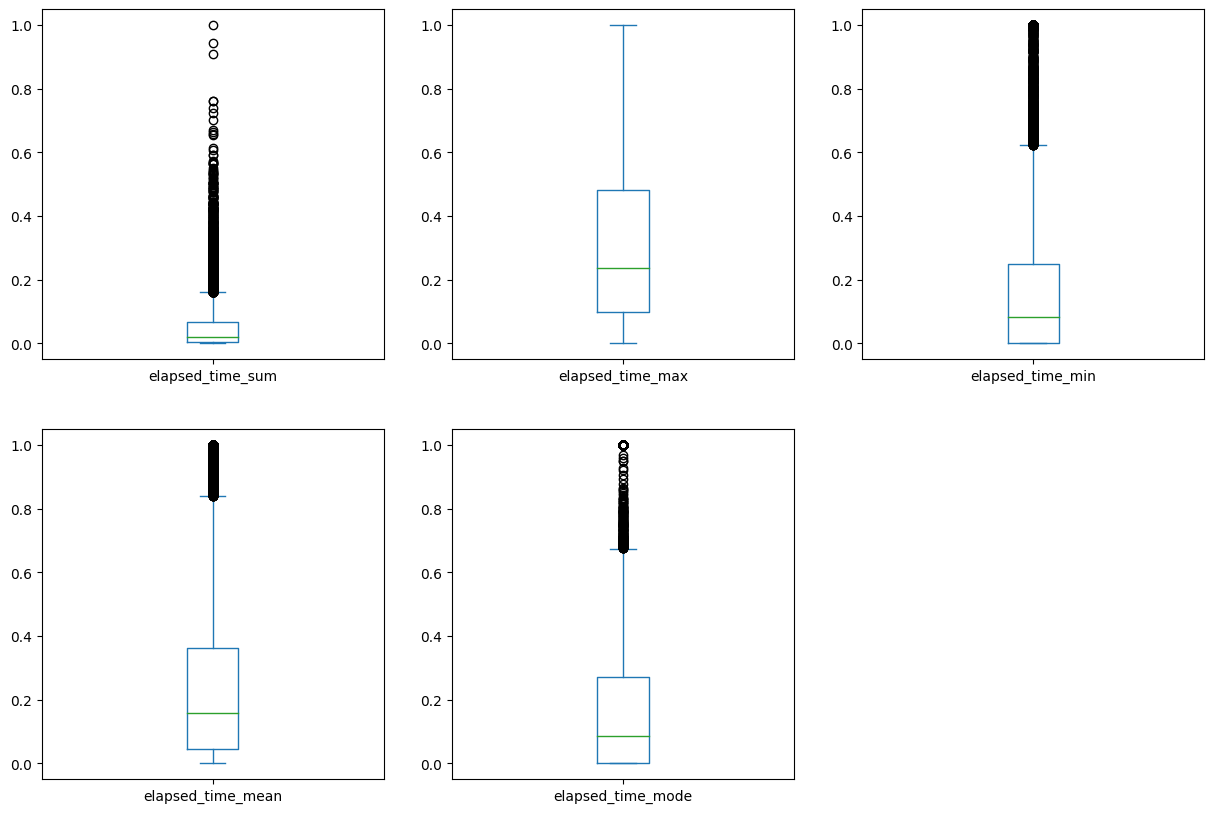

In [21]:
plot_numeric_features(df_features, 'elapsed_time')

## Data Selection

### Functions

In [22]:
def select_sessions(
        y: pd.DataFrame,
        random_state: int=1337,
        test_size: float=0.2,
        train_size:float=0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Select samples from the dataset for training, validation and testing.
    The test set is selected first, then the training set is selected from the 
    remaining sessions. And finally the validation set is selected from the
    remaining sessions.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    random_state : int
        The random state to use.
    test_size : float
        The ratio of the sample to use for testing.
    train_size : float
        The ratio of the sample to use for training.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # set the random seed
    np.random.seed(random_state)

    # shuffle the session ids
    np.random.shuffle(all_session_ids)

    # select the session ids for the test set
    test, remainder = train_test_split(all_session_ids, test_size=1-test_size)

    # split the dataset into train and validation sets
    train, val = train_test_split(remainder, test_size=1-train_size)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [23]:
def create_feature_dataset(df_features:pd.DataFrame,
                           df_source_labels:pd.DataFrame,
                           session_list: list,
                           feature_list:list,
                           level_group:str=None,
                           include_question:bool=True,
                           expand_question:bool=False) -> np.array:
    """
    Creates the feature dataset for the given level group and session list.
    If the level group is not specified it will create the dataset for all level groups.

    Parameters
    ----------
    df_features : pd.DataFrame
        The dataset of prepared features (by session_id and level_group).
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).
    session_list : list
        The list of session ids to create the dataset for.
    level_group : str, optional
        The level group to create the dataset for, by default None
    feature_list : list
        The list of features to include in the dataset.
    include_question : bool, optional
        Whether to include the question number in the dataset as the first set of
        columns, by default True
    expand_question : bool, optional
        Whether to expand the question number into a one-hot vector to each item in the 
        case of a multi-dimensional feature, by default False

    Returns
    -------
    np.array
        The feature dataset.
    """
    # get the features and labels for the given level group
    if level_group is None:
        logging.info('Creating the dataset for all level groups')
        df_features_group = df_features.query('session_id in @session_list')
        df_labels_group = df_source_labels.query('session_id in @session_list')
    else:
        logging.info('Creating the dataset for level group: %s', level_group)
        df_features_group = df_features.query('level_group == @level_group and session_id in @session_list')
        df_labels_group = df_source_labels.query('level_group == @level_group and session_id in @session_list')

    # sort the df_labels_group
    df_labels_group = df_labels_group.sort_values(['session_id', 'question_num'])

    feature_dataset = []

    # get the features for each row in the level group labels dataset
    current_session_id = None
    df_session_features = None

    for index, row in tqdm(df_labels_group.iterrows(), total=df_labels_group.shape[0]):        
        session_id = int(row['session_id'])
        session_level_group = row['level_group']
        question_num = int(row['question_num'])

        # get the features for the session
        if session_id != current_session_id:
            current_session_id = session_id
            df_session_features = df_features_group.query('session_id == @session_id')

        # get the level group features
        df_level_group_features = df_session_features.query('level_group == @session_level_group')

        # check if the session has features
        if df_level_group_features.shape[0] == 0:
            raise Exception(f'No features for session {session_id}, level group {session_level_group}!')
                            
        # get the features for the row
        row_features = []

        # get the question number one-hot encoded
        question_num_one_hot = np.zeros(18, dtype=np.int8)
        question_num_one_hot[question_num-1] = 1

        if include_question:
            row_features.extend(question_num_one_hot)

        for feature in feature_list:
            feature_value = df_level_group_features[feature].values[0]

            # check if the feature value is iterable
            if isinstance(feature_value, Iterable):
                if expand_question:
                    # reshape the question array to match the feature array shape
                    question_reshaped = np.tile(
                        question_num_one_hot, 
                        (feature_value.shape[0], 1))
                    
                    # add the question columns to the feature array
                    feature_value = np.hstack((question_reshaped, feature_value))

                row_features.extend(feature_value)
            else:
                row_features.append(feature_value)

        # add the row features to the output dataset
        feature_dataset.append(row_features)

    return np.array(feature_dataset, dtype=np.float32)

In [24]:
def create_label_dataset(session_list: list,
                          df_source_labels:pd.DataFrame) -> np.array:
    """
    Create the y_true values for the given session list.

    Parameters
    ----------
    session_list : list
        The list of session ids to create the dataset for.
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).

    Returns
    -------
    np.array
        The y_true dataset.
    """
    # get the relevant sessions
    answers = df_source_labels \
        .query('session_id in @session_list') \
        .sort_values(by=['session_id', 'question_num']) \
        .correct \
        .values
    
    return np.array(answers, dtype=np.int8)

In [25]:
def get_feature_dataset(features:pd.DataFrame,
                        y:pd.DataFrame,
                        feature_list:list,
                        train: list,
                        val: list,
                        test: list,
                        include_question:bool=True,
                        expand_question:bool=False) -> np.array:
    """
    Create a dictionary containing the features for the train,
    validation and test datasets.

    Parameters
    ----------
    features : pd.DataFrame
        The dataset of prepared features (by session_id and level_group).
    y : pd.DataFrame
        The dataset containing the training labels (y_True).
    feature_list : list
        The list of features to include in the dataset.
    train : list
        The list of session ids for the training dataset.
    val : list
        The list of session ids for the validation dataset.
    test : list
        The list of session ids for the test dataset.
    include_question : bool, optional
        Whether to include the question number in the dataset as the first set of
        columns, by default True
    expand_question : bool, optional
        Whether to expand the question number into a one-hot vector to each item in the
        case of a multi-dimensional feature, by default False

    Returns
    -------
    dict
        The dictionary containing the feature datasets for the train, validation and test
    """
    feature_dataset = {}
    for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
        feature_dataset[name] = {}

        # get the X values
        feature_dataset[name]['X'] = create_feature_dataset(
            df_features=features,
            df_source_labels=y,
            session_list=session_list,
            feature_list=feature_list,
            include_question=include_question,
            expand_question=expand_question)
        
        # get the y values
        feature_dataset[name]['y'] = create_label_dataset(
            session_list=session_list,
            df_source_labels=y)

    return feature_dataset

### Create Datasets

In [26]:
random_state = 51

In [27]:
# split the dataset into train, validation and test sets
train, val, test = select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Function

In [28]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    figsize : Tuple[int, int]
        The size of the figure to plot.

    Returns
    -------
    None
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [29]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    figsize : Tuple[int, int]
        The size of the figure to plot.

    Returns
    -------
    None
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [30]:
def optimize_f1(y_true: np.ndarray, 
                y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [31]:
def test_model(
        model,
        history: callbacks.History,
        X: np.ndarray,
        y: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        show_plots: bool = True) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X : np.ndarray
        The training and validation features combined.
    y: np.ndarray
        The training and validation labels combined.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    if show_plots:
        plot_loss(history)
        plot_accuracy(history)

    # score the train and validation data
    y_score = model.predict(X)

    # score the test data
    y_test_score = model.predict(X_test)

    threshold, _, _ = optimize_f1(y, y_score)
    #threshold = 0.5

    report = classification_report(y_test, y_test_score > threshold, zero_division=1)
    print(report)
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    return threshold, report

In [32]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [33]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [34]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        clear_learning: bool = False,
        show_plots: bool = True) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    # clear the learning output if required
    if clear_learning:
        clear_output()

    # combine the training and validation sets for testing
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    return test_model(model, history,
                      X_combined, y_combined,
                      X_test, y_test, 
                      show_plots=show_plots)

### Layer Definitions

In [35]:
def define_dense_layers(parent,
                        layer_count:int=1,
                        dense_units:int=128,
                        activation:str='relu',
                        l1_regulization:float=0.0,
                        l2_regulization:float=0.0,
                        dropout:float=0.0):
    """
    Create feed forward layers as per the parameters.

    Parameters
    ----------
    parent : keras.layers
        The parent layer.
    layer_count : int, optional
        The number of layers to create, by default 1
    dense_units : int, optional
        The number of units in each layer, by default 128
    activation : str, optional
        The activation function, by default 'relu'
    l1_regulization : float, optional
        The L1 regulization, by default 0.0
    l2_regulization : float, optional
        The L2 regulization, by default 0.0
    dropout : float, optional
        The dropout rate, by default 0.0

    Returns
    -------
    keras.layers
        The last layer created.
    """
    assert layer_count > 0, 'layer_count must be greater than 0'

    # add the first layer
    layers = k.layers.Dense(
        units=dense_units,
        activation=activation,
        kernel_regularizer=k.regularizers.l1_l2(l1_regulization, l2_regulization))(parent)

    if dropout > 0:
        layers = k.layers.Dropout(dropout)(layers)

    # add additional layers if required
    for _ in range(layer_count - 1):
        layers= define_dense_layers(
            parent=layers,
            layer_count=1,
            dense_units=dense_units,
            activation=activation,
            l1_regulization=l1_regulization,
            l2_regulization=l2_regulization,
            dropout=dropout)

    return layers

### Model Definitions

In [36]:
def train_simple_dense(dataset:dict,
                       input_shape,
                       output_shape,
                       dense_layer_count:int=1,
                       dense_units:int=128,
                       dense_activation:str='relu',
                       dense_l1_regulization:float=0.0,
                       dense_l2_regulization:float=0.0,               
                       dense_dropout:float=0.2,
                       train_epochs:int=10,
                       train_batch_size:int=25,
                       train_optimizer:k.optimizers=k.optimizers.RMSprop(learning_rate=0.0001),
                       train_loss:str='binary_crossentropy',
                       train_metrics:list=['accuracy'],
                       train_class_weight:dict=None) -> None:
    """
    Train a simple feed forward neural network consisting of dense layers.
    """
    # create the input layer
    input_layer = k.layers.Input(shape=input_shape)

    # create the dense layers
    dense_layers = define_dense_layers(
        parent=input_layer,
        layer_count=dense_layer_count,
        dense_units=dense_units,
        activation=dense_activation,
        l1_regulization=dense_l1_regulization,
        l2_regulization=dense_l2_regulization,
        dropout=dense_dropout)
    
    # define the model output
    model_output = k.layers.Dense(output_shape, activation='sigmoid')(dense_layers)

    # create the model
    model = k.Model(inputs=[input_layer], outputs=model_output)

    # plot the model architecture
    model.summary() 

    # train the model
    _, _ = train_and_test_model(
        model=model,
        X_train = dataset['train']['X'],
        y_train= dataset['train']['y'],
        X_val = dataset['val']['X'],
        y_val= dataset['val']['y'],
        X_test = dataset['test']['X'],
        y_test= dataset['test']['y'],
        epochs=train_epochs,
        batch_size=train_batch_size,
        optimizer=train_optimizer,
        loss=train_loss,
        metrics=train_metrics,
        class_weight=train_class_weight)

    return model      

### Train Models

#### Simple Dense Model

In [37]:
# create the simple model dataset
simple_model_dataset = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode'],
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-03-17 20:29:06 INFO     Creating the dataset for all level groups


  0%|          | 0/62910 [00:00<?, ?it/s]

2023-03-17 20:29:48 INFO     Creating the dataset for all level groups


  0%|          | 0/20970 [00:00<?, ?it/s]

2023-03-17 20:30:03 INFO     Creating the dataset for all level groups


  0%|          | 0/125784 [00:00<?, ?it/s]

In [38]:
print('train_X_shape:', simple_model_dataset['train']['X'].shape)
print('train_y_shape:', simple_model_dataset['train']['y'].shape)
print()

print('val_X_shape:', simple_model_dataset['val']['X'].shape)
print('val_y_shape:', simple_model_dataset['val']['y'].shape)


train_X_shape: (62910, 23)
train_y_shape: (62910,)

val_X_shape: (20970, 23)
val_y_shape: (20970,)


In [39]:
# define the simple model input shape
input_data = simple_model_dataset['train']['X']
simple_model_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_shape)

# define the output shape
output_data = simple_model_dataset['train']['y']
simple_model_output_shape = 1
print('output_shape', simple_model_output_shape)

simple_model_shape: 23
output_shape 1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 1024)              24576     
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-03-17 20:31:30.329325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 20:31:30.329845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 20:31:30.330019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 20:31:30.330123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

63/63 [==============================] - 1s 3ms/step - loss: 0.6514 - accuracy: 0.6874 - val_loss: 0.6203 - val_accuracy: 0.7085
Epoch 2/100
 1/63 [..............................] - ETA: 0s - loss: 0.6173 - accuracy: 0.7200

2023-03-17 20:31:31.216579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 0s 1ms/step - loss: 0.6046 - accuracy: 0.7051 - val_loss: 0.5874 - val_accuracy: 0.7085
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.7051 - val_loss: 0.5635 - val_accuracy: 0.7085
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5574 - accuracy: 0.7265 - val_loss: 0.5463 - val_accuracy: 0.7355
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5436 - accuracy: 0.7343 - val_loss: 0.5350 - val_accuracy: 0.7358
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5347 - accuracy: 0.7349 - val_loss: 0.5281 - val_accuracy: 0.7368
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5296 - accuracy: 0.7368 - val_loss: 0.5245 - val_accuracy: 0.7386
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5269 - accuracy: 0.7375 - val_loss: 0.5224 - val_accuracy: 0.7386
Epoch 9/100
63/63 [======

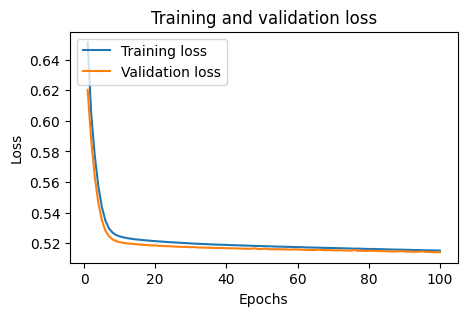

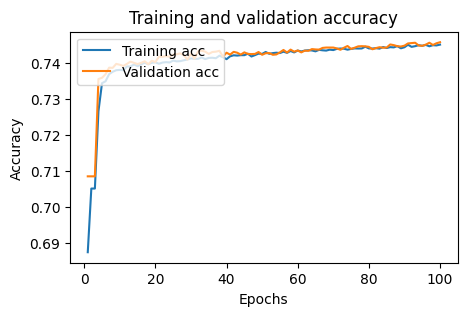

3931/3931 [==============================] - 2s 444us/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.53     37388
           1       0.80      0.79      0.80     88396

    accuracy                           0.72    125784
   macro avg       0.66      0.66      0.66    125784
weighted avg       0.72      0.72      0.72    125784

Optimized threshold for best F1: 0.64


In [40]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

It looks like the model might not have sufficient capacity, but perhaps the training loss is still decreasing. 
We can try to train for more epochs.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              24576     
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
63/63 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.6889 - val_loss: 0.6193 - val_accuracy: 0.7085
Epoch 2/1000
63/63 [==============================] - 0s 1ms/step - loss: 0.6032 - accuracy: 0.7051 - val_loss: 0.5859 - val_accuracy: 0.7085
Epoch 3/1000
63/63 [===============

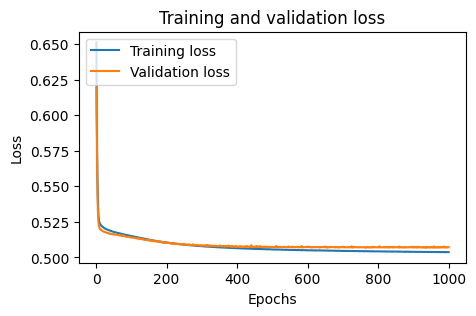

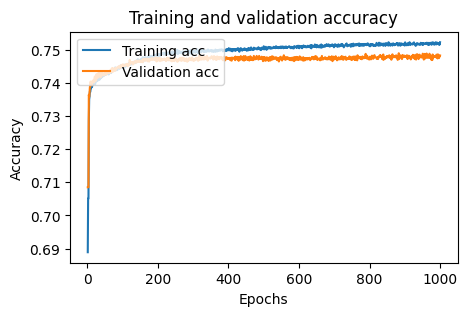

3931/3931 [==============================] - 2s 469us/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.54     37388
           1       0.80      0.80      0.80     88396

    accuracy                           0.72    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.72      0.72    125784

Optimized threshold for best F1: 0.63


In [41]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Increasing the number of epochs was beneficial, but the training loss is decreasing very slowly. 
We can try to increase the learning rate to see if that helps.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              24576     
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.7029 - val_loss: 0.5785 - val_accuracy: 0.7085
Epoch 2/1000
63/63 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.7239 - val_loss: 0.5421 - val_accuracy: 0.7360
Epoch 3/1000
63/63 [===============

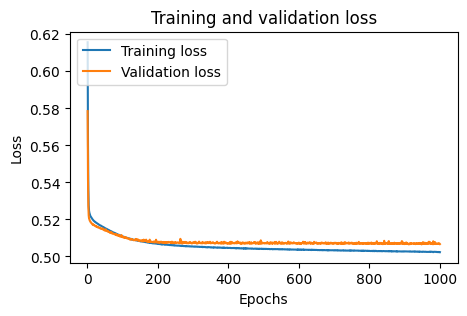

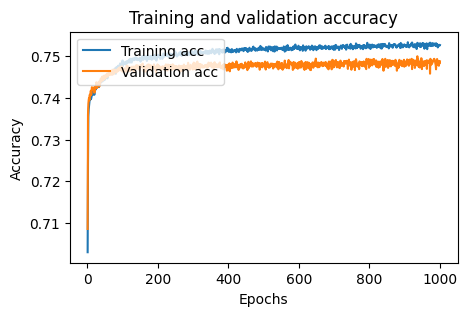

3931/3931 [==============================] - 2s 466us/step
              precision    recall  f1-score   support

           0       0.54      0.53      0.53     37388
           1       0.80      0.81      0.81     88396

    accuracy                           0.73    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.73      0.72    125784

Optimized threshold for best F1: 0.63


In [42]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=2e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

This results in more small up and down variations, but especially on the validation accuracy
These variations could possibly be attributed to the following few factors.

1. Noise in the data: The variations in the validation plot can indicate that there is some noise in the dataset. The model might have difficulty generalizing to this noise, causing small fluctuations in the validation accuracy.

2. Small batch size: If you are using a small batch size, the gradients computed during each update can be quite noisy, causing the variations in the validation accuracy. You can try increasing the batch size to see if the fluctuations are reduced.

3. Insufficient model capacity: If your model has low capacity, it might struggle to learn complex patterns in the data, leading to fluctuations in the validation accuracy. You can try increasing the model capacity by adding more layers or neurons.

4. High learning rate: A high learning rate can cause the optimizer to overshoot the optimal weights, resulting in fluctuations in the validation accuracy. You can try reducing the learning rate to make the updates more stable.

5. Randomness in data splits: The validation set might contain harder examples or a different distribution of classes, causing fluctuations in the validation accuracy. You can try changing the random seed or shuffling the data before splitting it to see if it has any impact on the fluctuations.

In this specific case the higher learning rate (3) was definitely a factor. Before moving on the the other factors, we will first try the following:

- Return to the previous learning rate
- Increase the number of epochs
- Increase the batch size

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              24576     
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
16/16 [==============================] - 0s 7ms/step - loss: 0.6672 - accuracy: 0.7013 - val_loss: 0.6521 - val_accuracy: 0.7085
Epoch 2/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.7051 - val_loss: 0.6340 - val_accuracy: 0.7085
Epoch 3/2000
16/16 [===============

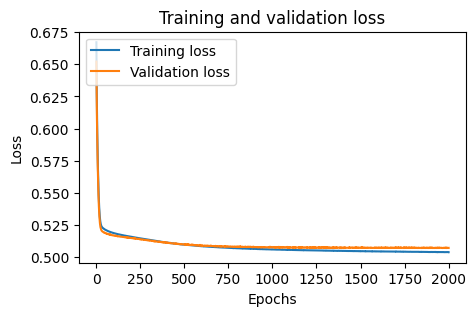

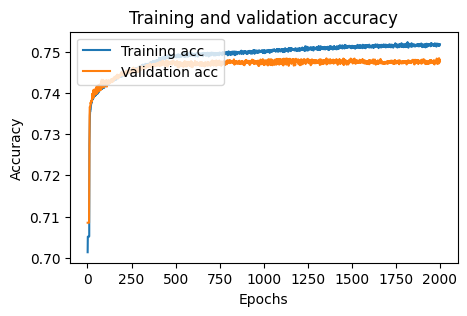

3931/3931 [==============================] - 2s 466us/step
              precision    recall  f1-score   support

           0       0.54      0.52      0.53     37388
           1       0.80      0.82      0.81     88396

    accuracy                           0.73    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.73      0.72    125784

Optimized threshold for best F1: 0.62


In [43]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=2000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

##### CHECKPOINT: 02-04-01

We will now retrain this model, but with class weights to account for the class imbalance.
An attempt will then be made to run this model in the Kaggle competition to obtain a result.

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_34 (Dense)            (None, 1024)              24576     
                                                                 
 dense_35 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
16/16 [==============================] - 0s 7ms/step - loss: 0.8895 - accuracy: 0.6106 - val_loss: 0.6763 - val_accuracy: 0.7059
Epoch 2/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.8766 - accuracy: 0.7056 - val_loss: 0.6637 - val_accuracy: 0.6988
Epoch 3/2000
16/16 [===============

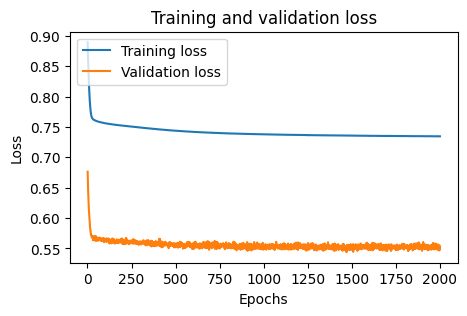

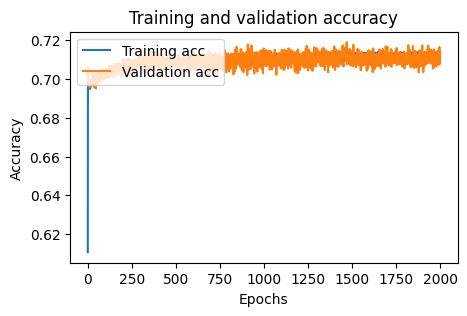

3931/3931 [==============================] - 2s 455us/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.54     37388
           1       0.80      0.80      0.80     88396

    accuracy                           0.72    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.72      0.72    125784

Optimized threshold for best F1: 0.47


In [48]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=2000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight={0: 2, 1: 1.0})

In [49]:
# save the model
model.save('../checkpoints/02-04-01.h5')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_10 (Dense)            (None, 10240)             245760    
                                                                 
 dense_11 (Dense)            (None, 1)                 10241     
                                                                 
Total params: 256,001
Trainable params: 256,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.7062 - val_loss: 0.5532 - val_accuracy: 0.7339
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5398 - accuracy: 0.7346 - val_loss: 0.5259 - val_accuracy: 0.7386
Epoch 3/100
63/63 [================

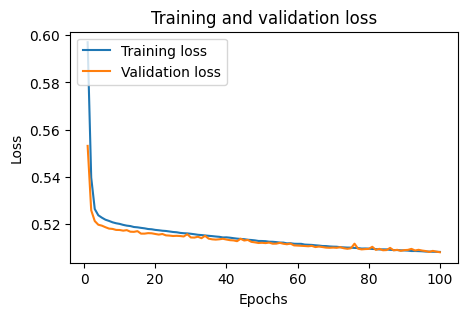

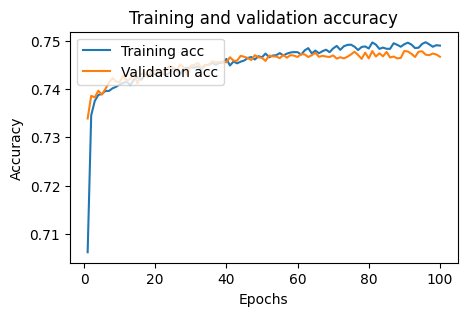

3931/3931 [==============================] - 2s 437us/step
              precision    recall  f1-score   support

           0       0.54      0.52      0.53     37388
           1       0.80      0.81      0.81     88396

    accuracy                           0.72    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.72      0.72    125784

Optimized threshold for best F1: 0.63


In [45]:
train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024*10,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=0.0001),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

##### Increase layers

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              24576     
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_17 (Dense)            (None, 1024)              1049

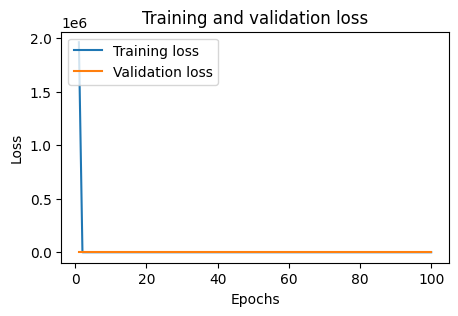

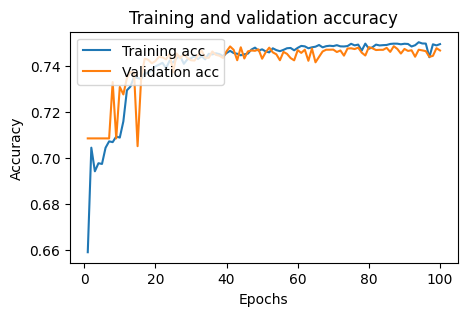

3931/3931 [==============================] - 3s 652us/step
              precision    recall  f1-score   support

           0       0.54      0.51      0.53     37388
           1       0.80      0.82      0.81     88396

    accuracy                           0.73    125784
   macro avg       0.67      0.66      0.67    125784
weighted avg       0.72      0.73      0.72    125784

Optimized threshold for best F1: 0.59


In [46]:
train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-2),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

That seemed quite good on the F1 score, but the validation accuracy is very volatile and it is possibly just a fluke.
We can try to add some regularization to the model to see if that helps.

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_23 (Dense)            (None, 1024)              24576     
                                                                 
 dense_24 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_25 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_26 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_27 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_28 (Dense)            (None, 1024)              1049

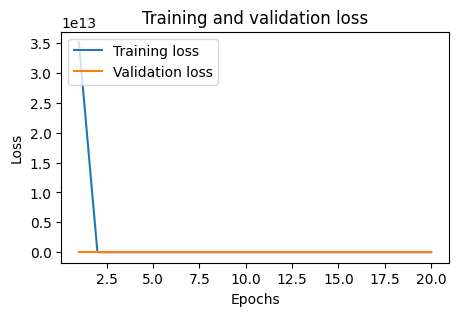

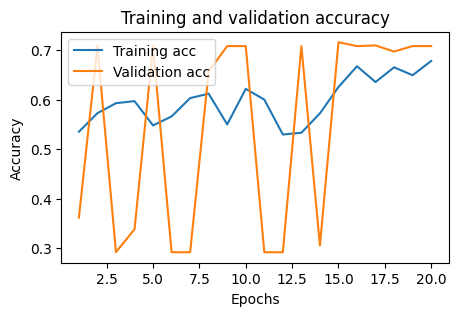

3931/3931 [==============================] - 3s 728us/step
              precision    recall  f1-score   support

           0       0.41      0.61      0.49     37388
           1       0.79      0.63      0.70     88396

    accuracy                           0.62    125784
   macro avg       0.60      0.62      0.59    125784
weighted avg       0.68      0.62      0.64    125784

Optimized threshold for best F1: 0.68


In [47]:
train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=1e-6,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=20,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=5e-2),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)